# Task 10.2. Segmentation by division and merging
---
***Author: Piotr Skalski***

## 1. Imports

In [247]:
import numpy as np
import cv2
import os
import pprint
from tqdm import tqdm

import display_util

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Primary settings

In [248]:
SOURCE_DIR = "./../data/"
IMAGE_NAME = "umbrealla.png"

## 3. Loading images

In [249]:
# building path to file
image_path = os.path.join(SOURCE_DIR, IMAGE_NAME)
# loading files
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image = image[:, :, 0]

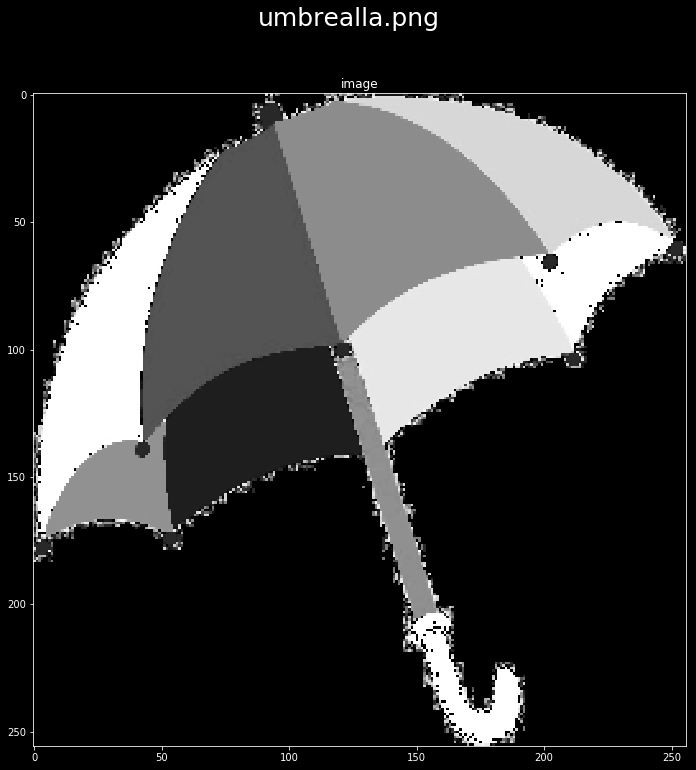

In [250]:
display_util.image(image, IMAGE_NAME, size=(12,12))

## 4. Segmentation by division and merging method

### 4.1. Settings

In [251]:
MIN_SEGMENT_SHAPE = (8, 8)
STD_DEV_DIVISION_THRESHOLD = 0.5
HUE_MERGE_THRESHOLD = 2.0
MIN_PIXEL_THRESHOLD = 100

### 4.2. Implementation

In [252]:
def quadruple(segment, segment_anchor):
    segment_shape = segment.shape
    y_marker = segment_shape[0] // 2
    x_marker = segment_shape[1] // 2
    return [
        (segment[:y_marker, :x_marker], segment_anchor),
        (segment[:y_marker, x_marker:], (segment_anchor[0], segment_anchor[1] + x_marker)),
        (segment[y_marker:, :x_marker], (segment_anchor[0] + y_marker, segment_anchor[1])),
        (segment[y_marker:, x_marker:], (segment_anchor[0] + y_marker, segment_anchor[1] + x_marker))
    ]

In [253]:
def split(segment, segment_anchor, index, seg_res, m_res, segment_index_cache, min_segment_shape = (8, 8), std_dev_devision_threshold = 1.0):
    segment_shape = segment.shape
    segment_std_dev = segment.std()
    
    if (segment_shape[0] >= min_segment_shape[0] and segment_shape[1] >= min_segment_shape[1] and segment_std_dev > std_dev_devision_threshold):
        segment_quarters = quadruple(segment, segment_anchor)
        for sub_segment, sub_segment_anchor in segment_quarters:
            seg_res, m_res, segment_index_cache, index = split(sub_segment, sub_segment_anchor, index, seg_res, m_res, segment_index_cache, min_segment_shape, std_dev_devision_threshold)
        return seg_res, m_res, segment_index_cache, index
    else:
        seg_res[
            segment_anchor[0]:segment_anchor[0] + segment_shape[0], 
            segment_anchor[1]:segment_anchor[1] + segment_shape[1]
        ] = index
        m_res[
            segment_anchor[0]:segment_anchor[0] + segment_shape[0], 
            segment_anchor[1]:segment_anchor[1] + segment_shape[1]
        ] = segment.mean()
        segment_index_cache[index] = (segment_anchor, segment_shape)
        index += 1
        return seg_res, m_res, segment_index_cache, index

In [254]:
def find_surrounding_segments(index_matrix, segment_anchor, segment_shape):
    matrix_shape = index_matrix.shape
    segment_value = index_matrix[segment_anchor]
    start_y_index = max(0, segment_anchor[0] - 1)
    end_y_index = min(matrix_shape[0], segment_anchor[0] + segment_shape[0] + 1) 
    start_x_index = max(0, segment_anchor[1] - 1)
    end_x_index = min(matrix_shape[1], segment_anchor[1] + segment_shape[1] + 1)
    segment = index_matrix[start_y_index:end_y_index, start_x_index:end_x_index]
    segment_indexed = np.unique(segment)
    return np.array([value for value in segment_indexed if value != segment_value and value != 0])

In [255]:
def merge(index_matrix, mean_matrix, segment_index_cache, hue_merge_threshold):
    current_index = 1
    max_index = len(segment_index_cache)
    
    while current_index < max_index:
        segment_anchor, segment_shape = segment_index_cache[current_index]
        is_segment_used = index_matrix[segment_anchor] != current_index
        
        flag = 0
        if not is_segment_used:
            current_segment_mean = mean_matrix[segment_anchor]
            surrounding_segments_indexes = find_surrounding_segments(index_matrix, segment_anchor, segment_shape)
            for surrounding_segment_indexes in surrounding_segments_indexes:
                surrounding_segment_mean = mean_matrix[np.where(index_matrix == surrounding_segment_indexes)].mean()
                if (abs(surrounding_segment_mean - current_segment_mean) < hue_merge_threshold):
                    flag = 1
                    index_matrix[np.where(index_matrix == surrounding_segment_indexes)] = current_index
        
        if flag == 0:
            current_index += 1
            
    return index_matrix

In [256]:
def filter_segments(segments_matrix, min_pixels_threshold):
    all_segments_indexes = np.unique(segments_matrix)
    segments_matrix_filtered = np.zeros(segments_matrix.shape)
    current_index = 1
    for segments_index in all_segments_indexes:
        if np.where(segments_matrix == segments_index)[0].size > min_pixels_threshold:
            segments_matrix_filtered[np.where(segments_matrix == segments_index)] = current_index
            current_index += 1
    return segments_matrix_filtered

In [257]:
def segmentation(image, min_segment_shape = (8, 8), std_dev_devision_threshold = 1.0, hue_merge_threshold = 5, min_pixels_threshold = 100):
    image_shape = image.shape
    seg_res = np.zeros(image_shape)
    m_res = np.zeros(image_shape)
    segment_index_cache = {}
    index = 1
    
    # DIVISION PHASE
    seg_res, m_res, segment_index_cache, index = split(image, (0, 0), index, seg_res, m_res, segment_index_cache, min_segment_shape, std_dev_devision_threshold)
    index_matrix = np.copy(seg_res)
    mean_matrix = np.copy(m_res)
    
    # MERGE PHASE
    seg_res = merge(seg_res, m_res, segment_index_cache, hue_merge_threshold)
    segments_matrix_no_filter = np.copy(seg_res)
    
    # FILTRATION PHASE
    segments_matrix_filter = filter_segments(seg_res, min_pixels_threshold)
    
    return index_matrix, mean_matrix, segment_index_cache, segments_matrix_no_filter, segments_matrix_filter

In [258]:
index_matrix, mean_matrix, segment_index_cache, segments_matrix_no_filter, segments_matrix_filter = segmentation(image, MIN_SEGMENT_SHAPE, STD_DEV_DIVISION_THRESHOLD, HUE_MERGE_THRESHOLD, MIN_PIXEL_THRESHOLD)

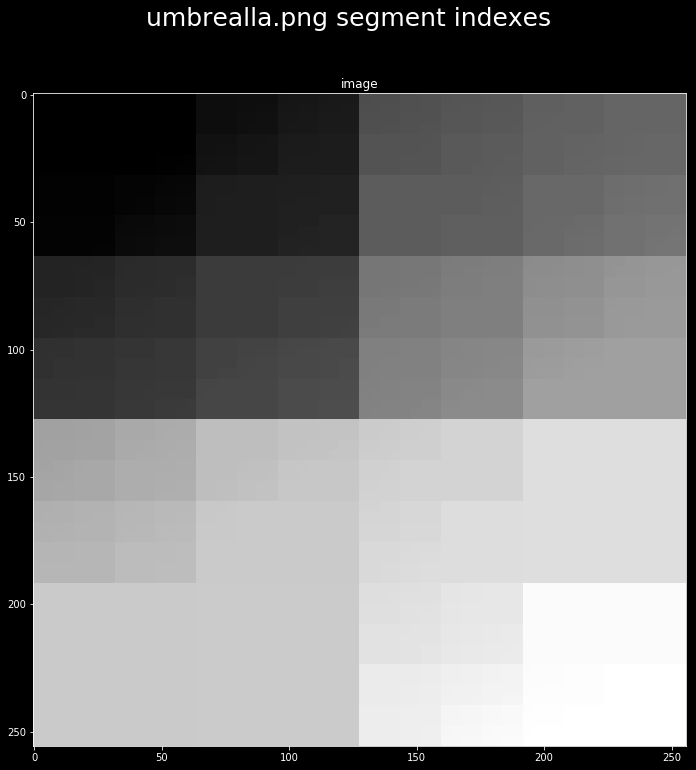

In [259]:
display_util.image(index_matrix, IMAGE_NAME + " segment indexes", size=(12,12))

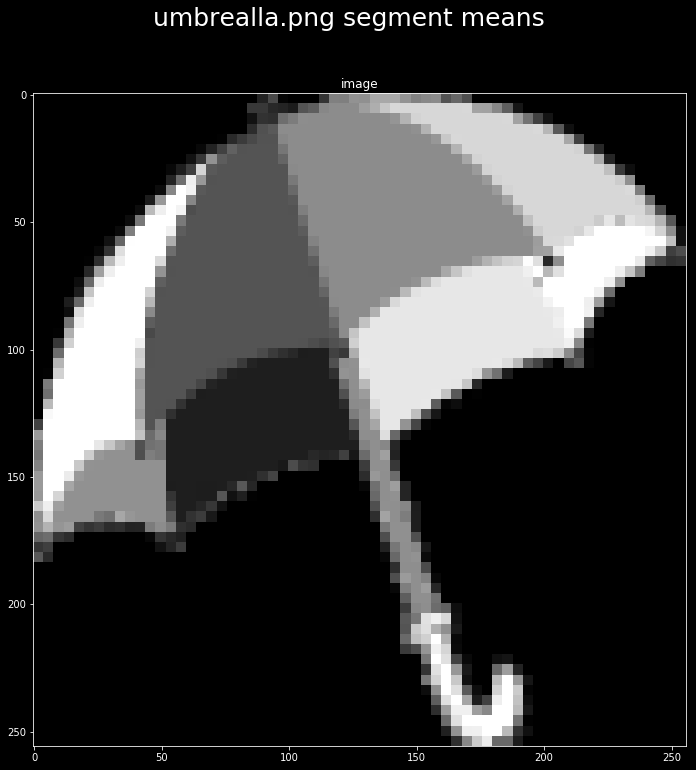

In [260]:
display_util.image(mean_matrix, IMAGE_NAME + " segment means", size=(12,12))

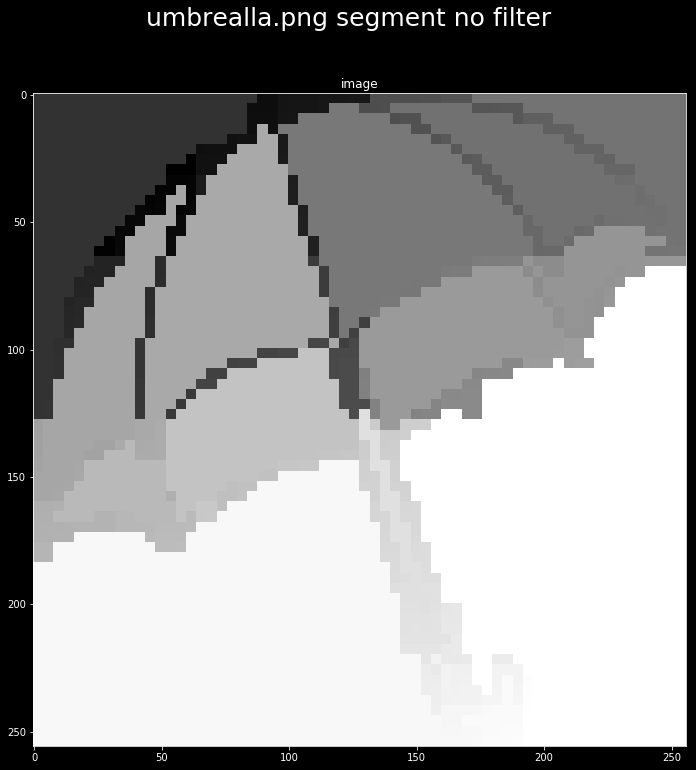

In [261]:
display_util.image(segments_matrix_no_filter, IMAGE_NAME + " segment no filter", size=(12,12))

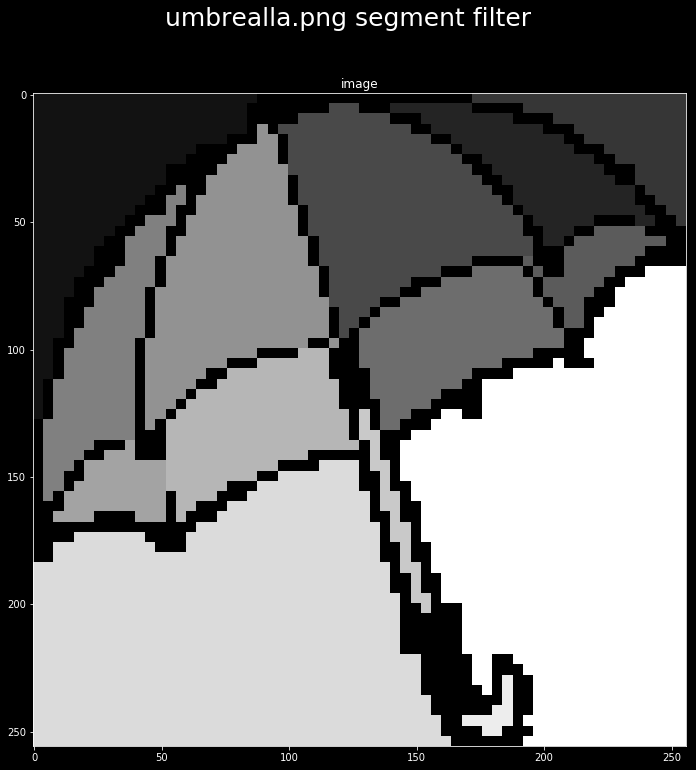

In [262]:
display_util.image(segments_matrix_filter, IMAGE_NAME + " segment filter", size=(12,12))